In [1]:
import torch
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
from visualization_utils import preprocess_image, convert_to_grayscale
from guided_backprop import GuidedBackprop

In [2]:
BASE_DIR = '..'
COUNTRY = 'malawi_2016','ethiopia_2015','nigeria_2015'
CNN_SAVE_DIR = os.path.join(BASE_DIR, 'models', 'trained_model.pt')

In [4]:
model = torch.load(CNN_SAVE_DIR, map_location=torch.device('cpu'))
model = model.eval()

In [6]:
os.listdir('images/')

['ethopia1.png',
 'ethopia2.png',
 'ethopia3.png',
 'ethopia4.png',
 'ethopia5.png',
 'malawi1.png',
 'malawi2.png',
 'malawi3.png',
 'malawi4.png',
 'malawi5.png',
 'nigeria1.png',
 'nigeria2.png',
 'nigeria3.png',
 'nigeria4.png',
 'nigeria5.png',
 'nigeria6.png']

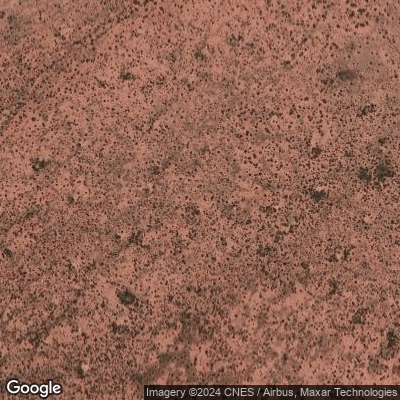

In [5]:
choice = 'ethopia2.png'
image_dir = f'images/{choice}'
image = Image.open(image_dir).convert('RGB')
image

In [6]:
proc_image = preprocess_image(image)
# prediction by model
preds = model(proc_image)
print('prediction:', preds)
target = torch.argmax(preds).item()

prediction: tensor([[ 2.4836,  0.0982, -2.6251]], grad_fn=<AddmmBackward0>)


In [8]:
GBP = GuidedBackprop(model)
guided_grads = GBP.generate_gradients(proc_image, target)
grayscale_guided_grads = convert_to_grayscale(guided_grads)

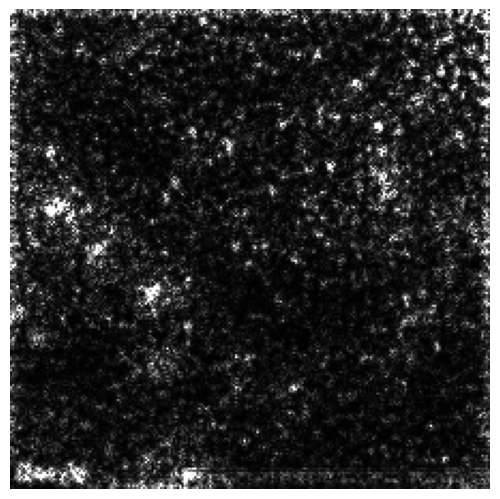

In [9]:
img = np.squeeze(grayscale_guided_grads.transpose(1, 2, 0))
fig = plt.figure(frameon=False)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
ax.imshow(img, cmap='gray', vmin=0, vmax=1)
fig.savefig('out.png', bbox_inches='tight', pad_inches=0)

prediction: tensor([[ 2.4836,  0.0982, -2.6251]], grad_fn=<AddmmBackward0>)


C:\Users\samee\AppData\Local\Temp\ipykernel_13608\737640706.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  heatmap_colored = plt.cm.get_cmap(colormap)(heatmap_normalized)[:, :, :3]


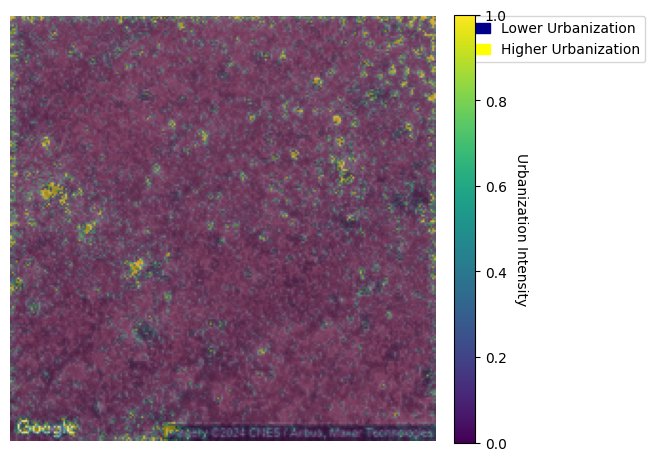

<Figure size 640x480 with 0 Axes>

In [10]:
import matplotlib.patches as mpatches
# Function to overlay heatmap on image
def overlay_heatmap_on_image(image, heatmap, alpha=0.5, colormap='viridis'):
    image_np = np.asarray(image)
    heatmap_normalized = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap))
    heatmap_colored = plt.cm.get_cmap(colormap)(heatmap_normalized)[:, :, :3]
    overlayed_image = (1 - alpha) * image_np + alpha * heatmap_colored * 255
    return overlayed_image.astype(np.uint8)

BASE_DIR = '..'
COUNTRY = 'malawi_2016', 'ethiopia_2015', 'nigeria_2015'
CNN_SAVE_DIR = os.path.join(BASE_DIR, 'models', 'trained_model.pt')

model = torch.load(CNN_SAVE_DIR, map_location=torch.device('cpu'))
model = model.eval()

os.listdir('images/')

choice = 'ethopia2.png'
image_dir = f'images/{choice}'
image = Image.open(image_dir).convert('RGB')

proc_image = preprocess_image(image)

preds = model(proc_image)
print('prediction:', preds)
target = torch.argmax(preds).item()

GBP = GuidedBackprop(model)
guided_grads = GBP.generate_gradients(proc_image, target)
grayscale_guided_grads = convert_to_grayscale(guided_grads)

# Overlay heatmap on the original image
overlayed_image = overlay_heatmap_on_image(image, np.squeeze(grayscale_guided_grads))

# Display the overlayed image with a colorbar and annotations
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(overlayed_image)
ax.axis('off')

# Create a colorbar with explicit Axes
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=np.min(grayscale_guided_grads), vmax=np.max(grayscale_guided_grads)))
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
cbar.set_label('Urbanization Intensity', rotation=270, labelpad=15)

# Add annotations or a legend to explain color mappings
low_density_patch = mpatches.Patch(color='darkblue', label='Lower Urbanization')
high_density_patch = mpatches.Patch(color='yellow', label='Higher Urbanization')
ax.legend(handles=[low_density_patch, high_density_patch], bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.show()

# Save the overlayed image with annotations
plt.savefig('overlayed_out_with_annotations.png', bbox_inches='tight', pad_inches=0)


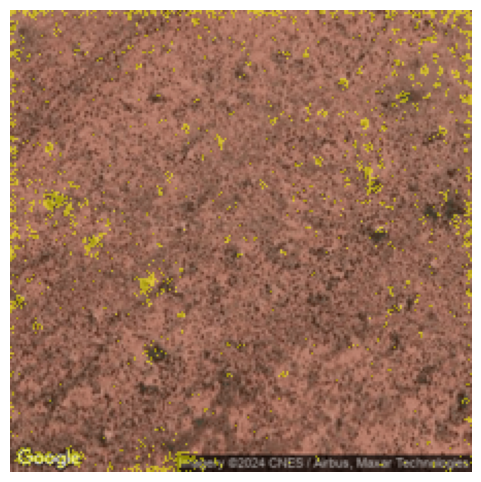

In [11]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
def highlight_high_activation_areas(image, heatmap, alpha=0.5, std_factor=2):
    # Calculate the mean and standard deviation of the heatmap
    mean = np.mean(heatmap)
    std_dev = np.std(heatmap)
    # Calculate the threshold using the mean and standard deviation
    threshold = mean + (std_factor * std_dev)
    # Create a mask for the areas above the threshold
    mask = heatmap > threshold
    # Create an RGBA image for the overlay with the same size as the original image and a transparent background
    overlay = np.zeros((*image.size[::-1], 4), dtype=np.uint8)
    # Apply yellow color to the mask
    overlay[mask, 0] = 255  # Red channel, full intensity for yellow color
    overlay[mask, 1] = 255  # Green channel, full intensity for yellow color
    overlay[mask, 3] = int(alpha * 255)  # Alpha channel, for transparency
    # Convert the RGBA overlay to a PIL image
    overlay_image = Image.fromarray(overlay, 'RGBA')
    # Overlay the RGBA image on the original image
    combined = Image.alpha_composite(image.convert('RGBA'), overlay_image)
    return combined
# Assume 'image' and 'grayscale_guided_grads' are already defined as per your previous code
# Apply the function to highlight higher activation areas
highlighted_image = highlight_high_activation_areas(image, np.squeeze(grayscale_guided_grads), alpha=0.5, std_factor=2)
# Display the highlighted image
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(highlighted_image)
ax.axis('off')
plt.show()